In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from itertools import product
from multiprocessing import Pool
from pprint import pprint

## Generating random networks

### types of random network

![types of random networks](./attachments/networkx_random_vs_scalefree_smallworld.jpg)

### Random network (Erdos Renyi)

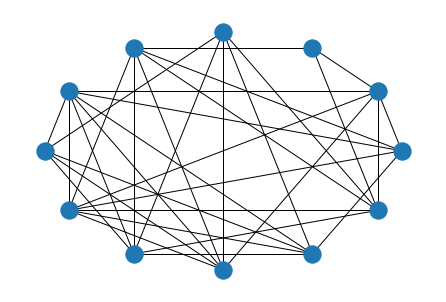

In [2]:
G1 = nx.erdos_renyi_graph(n=12, p=0.5)
nx.draw_circular(G1)

In [3]:
type(G1)

networkx.classes.graph.Graph

### Small World network (Watts Strogatz)

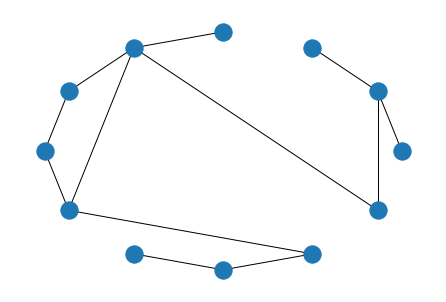

In [4]:
G2 = nx.watts_strogatz_graph(n=12, k=2 , p=1/2)
nx.draw_circular(G2)

### Random network (Barabasi Albert)

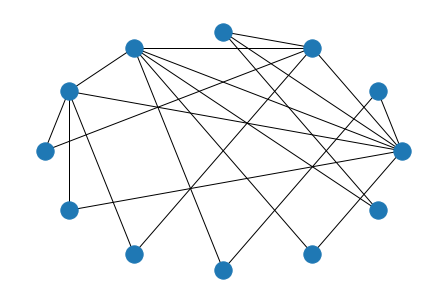

In [5]:
G3 = nx.barabasi_albert_graph(n=12, m=2)
nx.draw_circular(G3)

## Network metrics

In [6]:
from scripts.networkx_metrics import network_metrics

In [7]:
for G in [G1, G2, G3]:
    pprint(network_metrics(G))
    print("\n")

{'avg degree': 5.67,
 'avg distance': 1.52,
 'degree distribution': array([0, 0, 0, 1, 0, 3, 6, 2]),
 'nb components': 1}


{'avg degree': 2.0,
 'avg distance': 3.11,
 'degree distribution': array([0, 4, 5, 2, 1]),
 'nb components': 1}


{'avg degree': 3.33,
 'avg distance': 1.88,
 'degree distribution': array([0, 0, 7, 1, 0, 2, 1, 1]),
 'nb components': 1}




## Generating random network with similar metrics

Generating different types of network given an expected average node degree

In [8]:
from scripts.networkx_random_graphs import generate_random_graph

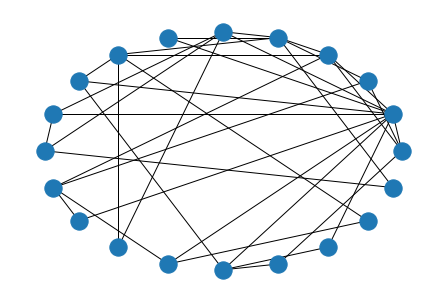

In [9]:
network_type = 'scale free' # ['random', 'small world', 'scale free']

mygraph = generate_random_graph(network_type=network_type, nb_nodes=20, avg_degree=4)
nx.draw_circular(mygraph)

In [10]:
pprint(network_metrics(mygraph))

{'avg degree': 3.6,
 'avg distance': 2.22,
 'degree distribution': array([0, 0, 7, 5, 3, 3, 1, 0, 0, 0, 1]),
 'nb components': 1}


<br>

Comparing different random graph for a fixed `(n, avg_degree)` parameters

{'avg degree': 7.38,
 'avg distance': 2.53,
 'degree distribution': array([ 0,  1,  0,  4,  9, 13, 13, 14, 16,  8, 10,  2,  6,  3,  0,  1]),
 'nb components': 1}


{'avg degree': 8.0,
 'avg distance': 2.48,
 'degree distribution': array([ 0,  0,  0,  0,  2,  3, 13, 19, 26, 16, 18,  2,  1]),
 'nb components': 1}


{'avg degree': 7.68,
 'avg distance': 2.38,
 'degree distribution': array([ 0,  0,  0,  1, 27, 19, 15,  8,  5,  6,  1,  3,  2,  0,  3,  0,  2,
        0,  1,  0,  1,  2,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  1]),
 'nb components': 1}




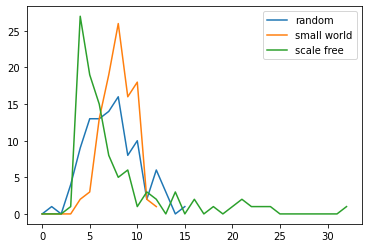

In [11]:
n = 100
avg_degree = 8
network_types = ['random', 'small world', 'scale free']

for option in network_types:
    G = generate_random_graph(option, n, avg_degree)
    pprint(network_metrics(G))   # show network metrics for each type of graph
    plt.plot(network_metrics(G)['degree distribution'], label=option)  # show degree distribution
    print("\n")
    
plt.legend(loc="upper right")

<br>

Comparing different random graph for multiple `(n, avg_degree)` parameters

In [12]:
def generate_graph_metadata(nx_type, N, k):
    dct = {'graph_type': nx_type, 'nb_nodes': N, 'expected_avg_degree': k}
    G = generate_random_graph(nx_type, N, k)
    dct.update(network_metrics(G))
    return dct

In [13]:
network_types = ['random', 'small world', 'scale free']
nb_nodes = [100, 200]
expected_avg_degree = np.arange(2,31,1).tolist()

# generate all possible combination of above parameters
settings = list(product(network_types, nb_nodes, expected_avg_degree))

In [14]:
# (multiprocessing) generate graph metadata for all settings
p = Pool()
result = p.starmap(generate_graph_metadata, settings)
p.close()
p.join()

### Storing network metadata

as a `pandas.DataFrame`

In [15]:
df = pd.DataFrame(result)
df

,graph_type,nb_nodes,expected_avg_degree,nb components,avg degree,avg distance,degree distribution
0,random,100,2,16,2.16,0.35,"[15, 11, 40, 21, 6, 5, 1, 1]"
1,random,100,3,8,2.46,0.59,"[7, 24, 27, 22, 7, 7, 4, 1, 1]"
2,random,100,4,4,3.90,0.87,"[3, 9, 15, 19, 17, 13, 13, 7, 2, 2]"
3,random,100,5,1,5.50,2.85,"[0, 2, 8, 8, 15, 21, 16, 12, 9, 5, 0, 3, 0, 1]"
4,random,100,6,1,5.98,2.74,"[0, 1, 4, 8, 9, 27, 17, 12, 8, 7, 3, 0, 3, 0, ..."
...,...,...,...,...,...,...,...
169,scale free,200,26,1,26.04,1.91,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23,..."
170,scale free,200,27,1,27.75,1.89,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
171,scale free,200,28,1,27.75,1.90,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
172,scale free,200,29,1,29.44,1.87,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


<br>

as a `xarray.Dataset`

In [16]:
ds = df.set_index(['graph_type', 'nb_nodes', 'expected_avg_degree']).to_xarray()
ds

<xarray.Dataset>
Dimensions:              (graph_type: 3, nb_nodes: 2, expected_avg_degree: 29)
Coordinates:
  * graph_type           (graph_type) object 'random' 'scale free' 'small world'
  * nb_nodes             (nb_nodes) int64 100 200
  * expected_avg_degree  (expected_avg_degree) int64 2 3 4 5 6 ... 27 28 29 30
Data variables:
    nb components        (graph_type, nb_nodes, expected_avg_degree) int64 16...
    avg degree           (graph_type, nb_nodes, expected_avg_degree) float64 ...
    avg distance         (graph_type, nb_nodes, expected_avg_degree) float64 ...
    degree distribution  (graph_type, nb_nodes, expected_avg_degree) object [...

## Comparing metrics

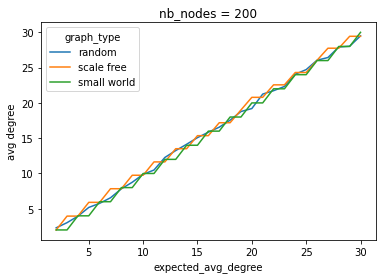

In [17]:
# Actual average degree 
n = 200
da = ds.sel(nb_nodes=n)['avg degree']
da.plot(x="expected_avg_degree", hue="graph_type")

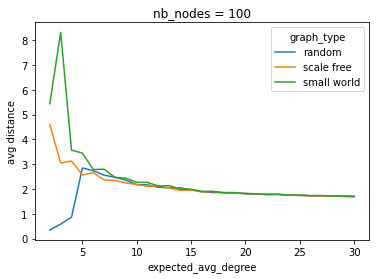

In [18]:
# Actual average distance 
n = 100
da = ds.sel(nb_nodes=n)['avg distance']
da.plot(x="expected_avg_degree", hue="graph_type")

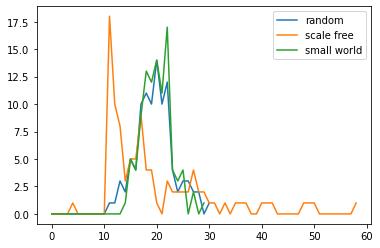

In [19]:
# Degree distribution
n = 100
k = 20

for i, label in enumerate(ds.graph_type.values):
    da = ds.sel(nb_nodes=n, expected_avg_degree=k)['degree distribution']
    plt.plot(da.values[i], label=label)
plt.legend(loc="upper right")

## Annex

The **`nx.barabasi_albert_graph()`** requires 2 parameters:
- **`n`**: the number of nodes,
- **`m`**: the initial number of connections

For a given number of nodes **`N`** and an expected average degree **`<k>`**, we can determine **`m`** with the following formula: 

$$\begin{align}
    <k> &= \sum_{k=m}^N ip_i                        && \text{average degree formula}\\
    &= \sum_{i=m}^N i \frac{2m(m+1)}{i(i+1)(i+2)}   &&\text{see Barabasi}\\
    &= \sum_{i=m}^N \frac{2m(m+1)}{(i+1)(i+2)} \\
    &= \sum_{i=m}^N \left(\frac{2m(m+1)}{i+1} - \frac{2m(m+1)}{i+2}\right) \\
    &= \sum_{i=m}^N \frac{2m(m+1)}{i+1} - \sum_{i=m}^N \frac{2m(m+1)}{i+2} \\
    &= \sum_{i=m}^N \frac{2m(m+1)}{i+1} - \sum_{j=m+1}^{N+1} \frac{2m(m+1)}{j+1}  &&\text{replacing by } j = i+1 \\
    &= \frac{2m(m+1)}{m+1} - \frac{2m(m+1)}{N+1}    &&\text{simplifying telescoping elements}\\
    &= 2m - \frac{2m(m+1)}{N+1}                     \tag 1 \\
\end{align}$$


  
Hence for a given **`N`** and **`<k>`**, the initial **`m-clique`** are the polynomial root of:

$$\begin{align}
    \frac{2}{N+1} &m^2 + \left(\frac{2}{N+1} -2 \right)m + k = 0 && \text{(using }k \text{ instead of } <k> \text{)} \\
    \Rightarrow &m = \frac{N}{2} \pm \frac{\sqrt{N^2 - 2Nk - 2k}}{2}  \\
    \Rightarrow &m = \frac{N}{2} - \frac{\sqrt{N^2 - 2Nk - 2k}}{2} &&\text{since } m \le N \tag 2\\
\end{align}$$


<br>  
But working with real numbers also implies:

$$\begin{align}
    0 &\le N^2 - 2Nk - 2k \\
    \Rightarrow k &\le \frac{N^2}{2(N+1)}  \tag 3\\
\end{align}$$